In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr30k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/datasets/adityajn105/flickr30k


In [2]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


def find_image_dir():
# Common Kaggle root
    base_input = '/kaggle/input'
    # Walk through the input directory to find where the images actually are
    for root, dirs, files in os.walk(base_input):
    # Look for the folder containing a high volume of jpg files
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None
IMAGE_DIR = find_image_dir()
OUTPUT_FILE = 'flickr30k_features.pkl'
if IMAGE_DIR:
    print(f" Found images at: {IMAGE_DIR}")
else:
    raise FileNotFoundError("Could not find the Flickr30k image directory. Please ensure the dataset is added to the notebook.")


# --- THE DATASET CLASS ---
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg'))]
        self.transform = transform
        self.img_dir = img_dir
    def __len__(self):
        return len(self.img_names)
    def __getitem__(self, idx):
        name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, name)
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), name


# --- REMAINDER OF THE PIPELINE (AS BEFORE) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = nn.Sequential(*list(model.children())[:-1]) # Feature vector only
model = nn.DataParallel(model).to(device)
model.eval()

transform = transforms.Compose([
transforms.Resize((224, 224)),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=4)
features_dict = {}

with torch.no_grad():
    for imgs, names in tqdm(loader, desc="Extracting Features"):
        feats = model(imgs.to(device)).view(imgs.size(0), -1)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)
print(f"Success! {len(features_dict)} images processed and saved to {OUTPUT_FILE}")

 Found images at: /kaggle/input/datasets/adityajn105/flickr30k/Images
cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s] 
Extracting Features: 100%|██████████| 249/249 [01:58<00:00,  2.10it/s]


Success! 31783 images processed and saved to flickr30k_features.pkl


In [3]:
import pandas as pd
import re
import torch

In [4]:
CAPTION_FILE = "/kaggle/input/datasets/adityajn105/flickr30k/captions.txt"

df = pd.read_csv(CAPTION_FILE)
df.columns = ["image", "caption"]
df["caption"] = df["caption"].astype(str)
print(df.head())


            image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .


In [5]:
def clean_text(text: str):
    text = text.lower()
    text = re.sub(r"[^a-z ]", "", text)
    return text

df["caption"] = df["caption"].apply(clean_text)


In [6]:
print(df.head())

            image                                            caption
0  1000092795.jpg   two young guys with shaggy hair look at their...
1  1000092795.jpg   two young  white males are outside near many ...
2  1000092795.jpg    two men in green shirts are standing in a yard 
3  1000092795.jpg        a man in a blue shirt standing in a garden 
4  1000092795.jpg             two friends enjoy time spent together 


In [7]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
# Initialize tokenizer
tokenizer = Tokenizer(BPE(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(
    vocab_size=1024,
    special_tokens=special_tokens
)

captions_list = df["caption"].tolist()

tokenizer.train_from_iterator(captions_list, trainer=trainer)

word2idx = tokenizer.get_vocab()
idx2word = {i: w for w, i in word2idx.items()}

print("BPE vocab size:", tokenizer.get_vocab_size())





BPE vocab size: 1024


In [35]:

tokenizer.save("tokenizer.json")


In [8]:
def encode_caption(caption, max_len=30):

    caption = "<start> " + caption + " <end>"

    ids = tokenizer.encode(caption).ids
    ids = ids[:max_len]
    pad_id = word2idx["<pad>"]
    while len(ids) < max_len:
        ids.append(pad_id)

    return torch.tensor(ids)


In [9]:
sample = df["caption"].iloc[0]

print("Caption:", sample)
print("Token IDs:", encode_caption(sample))
print("Decoded:", tokenizer.decode(encode_caption(sample).tolist()))


Caption:  two young guys with shaggy hair look at their hands while hanging out in the yard 
Token IDs: tensor([  1,  76, 111, 894,  56, 832, 449,  28, 321, 491,  44, 264, 524, 126,
        889, 167,  30,  38, 949,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])
Decoded: two young guys with sha gg y hair look at their hands while hanging out in the yard


In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df,test_size=0.15,random_state=0)

print("Train size:", len(train_df))
print("Val size:", len(val_df))


Train size: 135077
Val size: 23838


In [11]:
with open("flickr30k_features.pkl", "rb") as f:
    features = pickle.load(f)

print("Loaded features:", len(features))

Loaded features: 31783


In [12]:
from torch.utils.data import Dataset, DataLoader

class CaptionDataset(Dataset):
    def __init__(self, df, features):
        self.df = df
        self.features = features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img_name = self.df.iloc[idx]["image"]
        caption  = self.df.iloc[idx]["caption"]

        # Image feature vector: (2048,)
        img_feat = torch.tensor(features[img_name], dtype=torch.float)

        # Caption tokens: (max_len,)
        cap_ids = encode_caption(caption)

        return img_feat, cap_ids



In [13]:
train_dataset = CaptionDataset(train_df, features)
val_dataset   = CaptionDataset(val_df, features)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [14]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()

        # In(2048)  ---> Out(512)
        self.fc = nn.Linear(2048, hidden_size)

    def forward(self, x):

        # (batch, 2048) --> (batch, 512)
        x = self.fc(x)
        
        # (batch, 512)--> (1, batch, 512)
        return x.unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, hidden_size, vocab_size, embed_dim=256):
        super().__init__()

        # Input token IDs → Embedding vectors
        # (batch, seq_len) --> (batch, seq_len, 256)
        self.embed = nn.Embedding(vocab_size, embed_dim)

        # (seq_len, batch, 256) --->(seq_len, batch, 512)
        self.gru = nn.GRU(embed_dim, hidden_size)

        # (seq_len, batch, 512) ----> (seq_len, batch, vocab_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, captions, hidden):

        #  (batch, seq_len) ---> (batch, seq_len, 256)
        emb = self.embed(captions)

        # (batch, seq_len, 256)  ---> (seq_len, batch, 256) 
        emb = emb.permute(1, 0, 2)

        out, hidden = self.gru(emb, hidden)
        # out (seq_len, batch, 512)
        # hidden (1, batch, 512)

        preds = self.fc(out) 
        # (seq_len, batch, vocab_size)

        return preds, hidden


In [15]:
class CaptionModel(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super().__init__()

        self.encoder = Encoder(hidden_size)
        self.decoder = Decoder(hidden_size, vocab_size)

    def forward(self, img_fea, captions):

        # (batch, 2048)--> (1, batch, 512)
        hidden = self.encoder(img_fea)
        
        outputs, _ = self.decoder(captions, hidden)
        # (seq_len, batch, vocab_size)

        return outputs


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

vocab_size = tokenizer.get_vocab_size()

model = CaptionModel(hidden_size=512, vocab_size=vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [29]:
num_epochs = 10

train_losses = []
val_losses   = []

for epoch in range(num_epochs):

    # -------------------
    # TRAINING
    # -------------------
    model.train()
    total_train_loss = 0

    for img_feat, captions in train_loader:

        img_feat = img_feat.to(device)
        captions = captions.to(device)

        inputs  = captions[:, :-1]   # (batch, seq_len-1)
        targets = captions[:, 1:]    # (batch, seq_len-1)

        optimizer.zero_grad()

        outputs = model(img_feat, inputs)

        # (seq_len, batch, vocab) -->(batch, seq_len, vocab)
        outputs = outputs.permute(1, 0, 2)

        loss = criterion(
            outputs.reshape(-1, vocab_size),
            targets.reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    # -------------------
    # VALIDATION
    # -------------------
    model.eval()
    total_val_loss = 0

    with torch.no_grad():

        for img_feat, captions in val_loader:

            img_feat = img_feat.to(device)
            captions = captions.to(device)

            inputs  = captions[:, :-1]
            targets = captions[:, 1:]

            outputs = model(img_feat, inputs)
            outputs = outputs.permute(1, 0, 2)

            loss = criterion(
                outputs.reshape(-1, vocab_size),
                targets.reshape(-1)
            )

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}")


IndentationError: unexpected indent (3896080299.py, line 92)

In [20]:
torch.save(model.state_dict(), "caption_model.pth")
print("Model saved  caption_model.pth")


Model saved  caption_model.pth


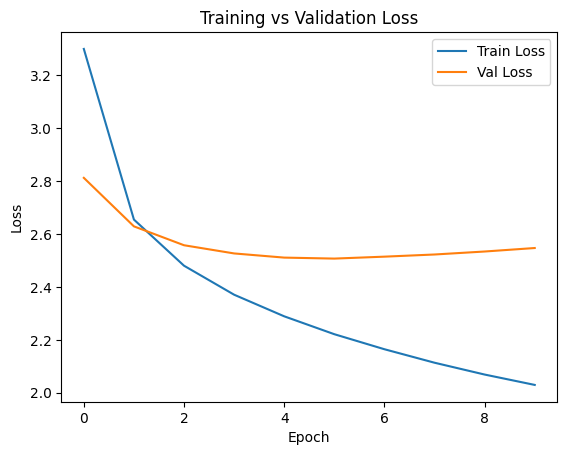

In [21]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

plt.legend()
plt.show()


In [22]:
model.load_state_dict(torch.load("caption_model.pth"))
model.eval()
print("Model load done")


Model load done


#  Evaluation

In [23]:
def generate_caption(img_feat, max_len=30):

    model.eval()

    img_feat = img_feat.unsqueeze(0).to(device) # (2048,)
    hidden = model.encoder(img_feat)  # (1, 1, 512)
    word_id = word2idx["<start>"]

    result = []

    for _ in range(max_len):
        word = torch.tensor([[word_id]]).to(device) # word: (1,1)
        out, hidden = model.decoder(word, hidden)# out: (1,1,vocab_size)
        pred_id = out.argmax(-1).item()
        if idx2word[pred_id] == "<end>":
            break
        result.append(idx2word[pred_id])
        word_id = pred_id

    return " ".join(result)


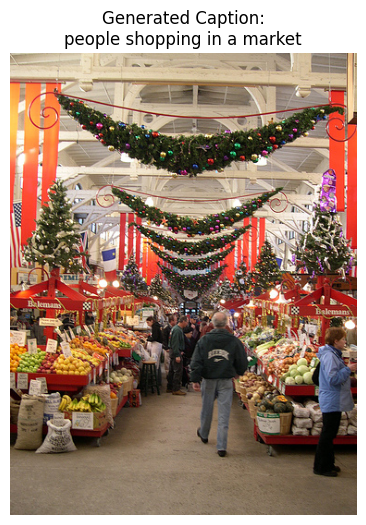

Ground Truth Caption:  customers buying produce during the holiday season 
Model Prediction:    people shopping in a market


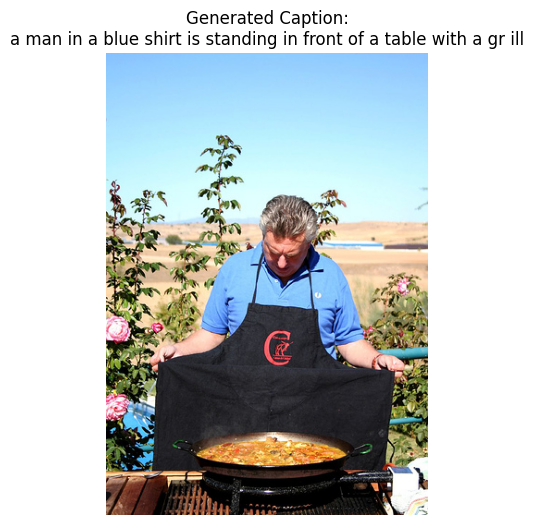

Ground Truth Caption:  a chef cooks on a wok on an outdoor grill 
Model Prediction:    a man in a blue shirt is standing in front of a table with a gr ill


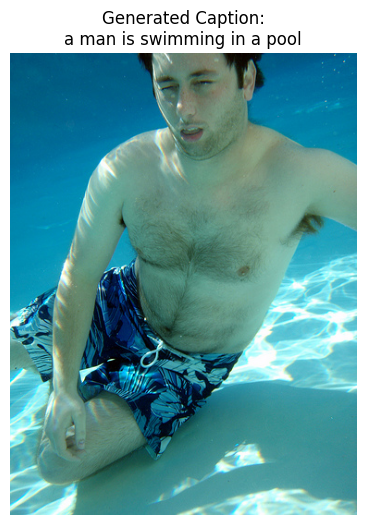

Ground Truth Caption:  a topless man in a swimsuit sits at the bottom of a pool filled with water 
Model Prediction:    a man is swimming in a pool


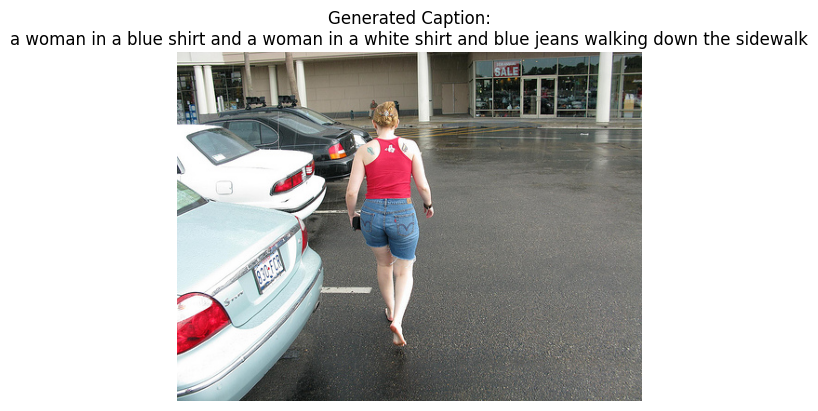

Ground Truth Caption:  a woman walking through a parking lot with no shoes on 
Model Prediction:    a woman in a blue shirt and a woman in a white shirt and blue jeans walking down the sidewalk


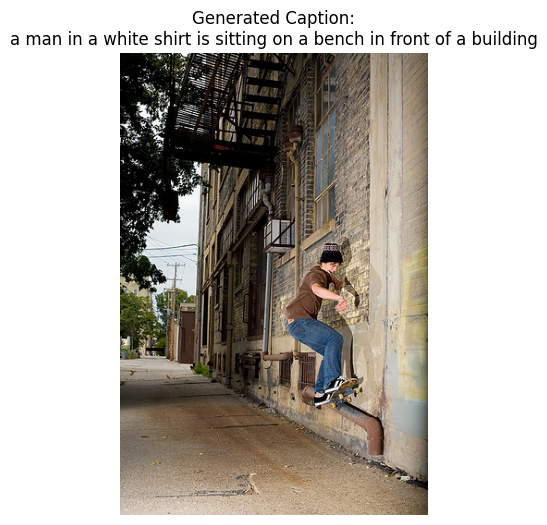

Ground Truth Caption:  a child on a skateboard flies through the air  along side a building 
Model Prediction:    a man in a white shirt is sitting on a bench in front of a building


In [25]:
import random

def show_predictions(model, val_df, val_dataset, IMAGE_DIR, num_samples=5):

    model.eval()

    # Pick random samples from validation set
    random_idxs = random.sample(range(len(val_dataset)), num_samples)

    for idx in random_idxs:

        # Get image filename + true caption
        img_name = val_df.iloc[idx]["image"]
        true_caption = val_df.iloc[idx]["caption"]

        # Load cached feature vector
        img_feat, _ = val_dataset[idx]

        # Generate caption from model
        pred_caption = generate_caption(img_feat)

        # Load actual image
        img_path = os.path.join(IMAGE_DIR, img_name)
        image = Image.open(img_path).convert("RGB")

        # Display image
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis("off")

        # Print captions
        plt.title("Generated Caption:\n" + pred_caption)
        plt.show()

        print("Ground Truth Caption:", true_caption)
        print("Model Prediction:   ", pred_caption)


show_predictions(model, val_df, val_dataset, IMAGE_DIR)


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_token_metrics(model, val_dataset, num_samples=500):

    model.eval()

    all_true_tokens = []
    all_pred_tokens = []

    for i in range(num_samples):

        img_feat, cap_ids = val_dataset[i]

        # True tokens
        true_tokens = val_df.iloc[i]["caption"].split()

        # Predicted tokens
        pred_tokens = generate_caption(img_feat).split()

        all_true_tokens.extend(true_tokens)
        all_pred_tokens.extend(pred_tokens)

    # Build shared vocabulary of tokens
    vocab = list(set(all_true_tokens + all_pred_tokens))

    # Convert into binary presence vectors
    true_vec = [1 if w in all_true_tokens else 0 for w in vocab]
    pred_vec = [1 if w in all_pred_tokens else 0 for w in vocab]

    precision = precision_score(true_vec, pred_vec)
    recall    = recall_score(true_vec, pred_vec)
    f1        = f1_score(true_vec, pred_vec)

    print("\nToken-Level Metrics on Validation Set")
    print("Precision:", precision)
    print("Recall:   ", recall)
    print("F1-score: ", f1)


# Run token evaluation
evaluate_token_metrics(model, val_dataset)



Token-Level Metrics on Validation Set
Precision: 0.5323741007194245
Recall:    0.23088923556942278
F1-score:  0.3220892274211099


In [27]:
!pip install nltk -q
from nltk.translate.bleu_score import corpus_bleu


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu4(model, val_dataset, num_samples=500):

    model.eval()

    references = []
    hypotheses = []

    for i in range(num_samples):

        img_feat, cap_ids = val_dataset[i]

        # Ground truth caption (string)
        true_caption = val_df.iloc[i]["caption"].split()

        # Predicted caption (greedy decoding)
        pred_caption = generate_caption(img_feat).split()

        # BLEU expects: list of references
        references.append([true_caption])
        hypotheses.append(pred_caption)

    bleu4 = corpus_bleu(references, hypotheses)

    print("BLEU-4 Score on Val Set:", bleu4)


evaluate_bleu4(model, val_dataset)


BLEU-4 Score on Val Set: 0.06259857317882649


In [30]:
import torch
import torch.nn.functional as F

def beam_search_caption(img_feat, beam_width=3, max_len=30):

    model.eval()

    # ---- Encode image feature ----
    # img_feat: (2048,)
    img_feat = img_feat.unsqueeze(0).to(device)

    # hidden: (1, 1, 512)
    hidden = model.encoder(img_feat)

    # ---- Start token ----
    start_id = word2idx["<start>"]
    end_id   = word2idx["<end>"]

    # Each beam stores: (sequence, score, hidden_state)
    beams = [([start_id], 0.0, hidden)]

    # ---- Beam Search Loop ----
    for _ in range(max_len):

        new_beams = []

        for seq, score, hid in beams:

            # If already ended, keep as is
            if seq[-1] == end_id:
                new_beams.append((seq, score, hid))
                continue

            # Last predicted word
            last_word = torch.tensor([[seq[-1]]]).to(device)

            # Decoder forward step
            out, new_hid = model.decoder(last_word, hid)

            # out: (1, 1, vocab_size)
            probs = F.log_softmax(out[0, 0], dim=0)

            # Top-k candidate words
            topk_probs, topk_ids = torch.topk(probs, beam_width)

            # Expand each candidate
            for i in range(beam_width):

                next_id = topk_ids[i].item()
                next_score = score + topk_probs[i].item()

                candidate_seq = seq + [next_id]

                new_beams.append((candidate_seq, next_score, new_hid))

        # Keep best k beams
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)
        beams = beams[:beam_width]

    # Best sequence
    best_seq = beams[0][0]

    # Convert IDs → Words (remove special tokens)
    words = [
        idx2word[idx]
        for idx in best_seq
        if idx not in [start_id, end_id, word2idx["<pad>"]]
    ]

    return " ".join(words)


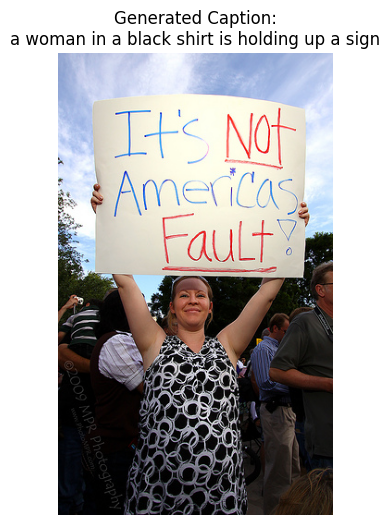

Ground Truth Caption:  a pregnant protester holding up a proamerica sign 
Model Prediction:    a woman in a black shirt is holding up a sign


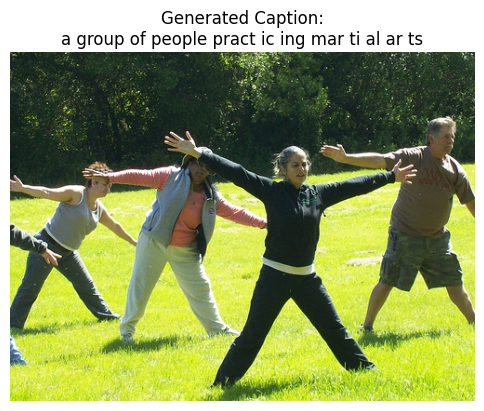

Ground Truth Caption:  a group of people doing exercise in the park
Model Prediction:    a group of people pract ic ing mar ti al ar ts


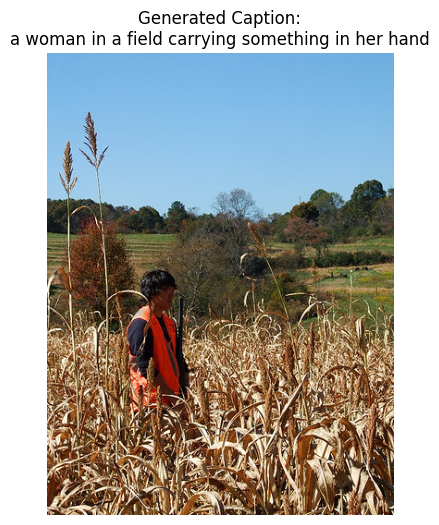

Ground Truth Caption:  a boy in orange suit is standing in a wheat field 
Model Prediction:    a woman in a field carrying something in her hand


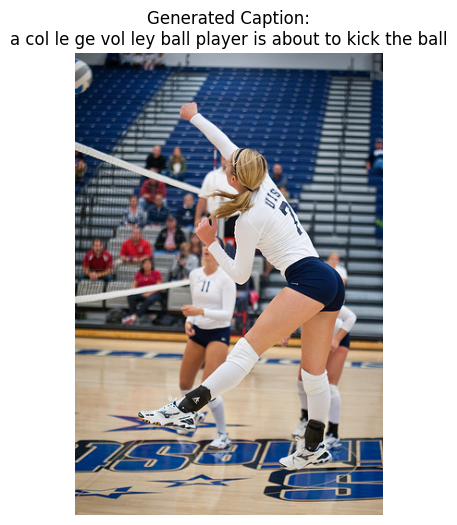

Ground Truth Caption:  a woman is playing for the usa volleyball team  spiking the ball over the net 
Model Prediction:    a col le ge vol ley ball player is about to kick the ball


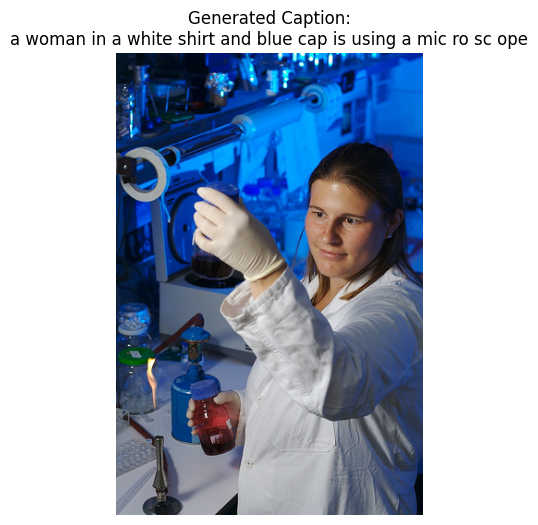

Ground Truth Caption:  woman in lab coat working 
Model Prediction:    a woman in a white shirt and blue cap is using a mic ro sc ope


In [33]:
import random

def show_predictions(model, val_df, val_dataset, IMAGE_DIR, num_samples=5):

    model.eval()

    # Pick random samples from validation set
    random_idxs = random.sample(range(len(val_dataset)), num_samples)

    for idx in random_idxs:

        # Get image filename + true caption
        img_name = val_df.iloc[idx]["image"]
        true_caption = val_df.iloc[idx]["caption"]

        # Load cached feature vector
        img_feat, _ = val_dataset[idx]

        # Generate caption from model
        pred_caption = beam_search_caption(img_feat, beam_width=5)

        # Load actual image
        img_path = os.path.join(IMAGE_DIR, img_name)
        image = Image.open(img_path).convert("RGB")

        # Display image
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis("off")

        # Print captions
        plt.title("Generated Caption:\n" + pred_caption)
        plt.show()

        print("Ground Truth Caption:", true_caption)
        print("Model Prediction:   ", pred_caption)


show_predictions(model, val_df, val_dataset, IMAGE_DIR)
